In [192]:
#importing python libraries
from pydantic import BaseModel
import os
from dotenv import load_dotenv
from typing import Annotated
from IPython.display import display,Image
import requests
import gradio as gr

In [193]:
#importing AI libraries
from langgraph.graph import StateGraph,add_messages
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START,END
from langchain.agents import Tool
from langgraph.checkpoint.memory import MemorySaver


In [194]:
gemini_model="gemini-2.0-flash"
load_dotenv(override=True)

True

In [195]:
gemini_api_key = os.getenv("GEMINI_API_KEY")

In [196]:
memory =MemorySaver()
llm = ChatGoogleGenerativeAI(model=gemini_model,api_key=gemini_api_key)
serper = GoogleSerperAPIWrapper()

In [197]:
class State(BaseModel):
    messages : Annotated[list,add_messages]

In [198]:
search_tool = Tool(
    name="SearchTool",
    func=serper.run,
    description="this is for searching info"
)

In [199]:
tools=[search_tool]

In [200]:
llm_as_tools = llm.bind_tools(tools)

In [201]:
graph_builder = StateGraph(State)

In [202]:
def chatbot(state:State)->State:
    result = llm_as_tools.invoke(state.messages)
    return State(messages=[result])

In [203]:
graph_builder.add_node("ChatBot",chatbot)
graph_builder.add_node("tools",ToolNode(tools))

In [204]:
graph_builder.add_conditional_edges("ChatBot",tools_condition,"tools")

In [205]:
graph_builder.add_edge("tools","ChatBot")
graph_builder.add_edge(START,"ChatBot")

In [206]:
graph = graph_builder.compile(checkpointer=memory)

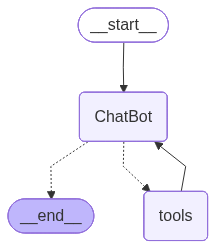

In [207]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [208]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input,history):
    result = graph.invoke(State(messages=[{"role":"user","content":user_input}]),config=config)
    return result['messages'][-1].content

In [209]:
gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7909
* To create a public link, set `share=True` in `launch()`.


In [211]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}, id='5a5b64dd-8ef7-44dc-9d07-b7930c2e5780'), AIMessage(content='I do not have access to that information. I am a language model.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--d6da3dcb-911e-4660-82df-5a50c2b2988e-0', usage_metadata={'input_tokens': 18, 'output_tokens': 16, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a47c8-731f-653f-8001-63d659f41e99'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-08T19:25:19.958355+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a47c8-6334-6418-8000-ae44d1d09b94'}}, tasks=(), interrupts=())

In [213]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}, id='5a5b64dd-8ef7-44dc-9d07-b7930c2e5780'), AIMessage(content='I do not have access to that information. I am a language model.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--d6da3dcb-911e-4660-82df-5a50c2b2988e-0', usage_metadata={'input_tokens': 18, 'output_tokens': 16, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a47c8-731f-653f-8001-63d659f41e99'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-08T19:25:19.958355+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a47c8-6334-6418-8000-ae44d1d09b94'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [Hu